In [1]:
from datasets import load_dataset

ds = load_dataset("uumlaut/VanGoghPaintings")

Resolving data files:   0%|          | 0/400 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


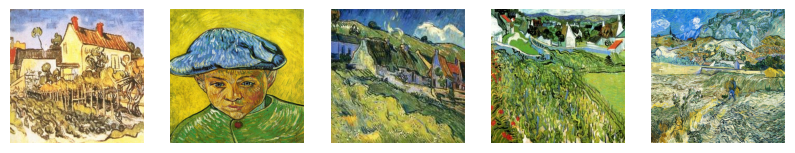

In [16]:
train_dataset = ds['train']

plt.figure(figsize=(10, 10))

for i in range(5):
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_dataset[i]['image'])
    print(train_dataset[i]['image'].size)
    plt.axis('off')
plt.show()

In [82]:
from torch.utils.data import Dataset, DataLoader
class CustomImageDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list 
        self.transform = transform    
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        image = self.image_list[idx] 
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(0)  

model = VAE(INPUT_DIM, H_DIM, Z_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum") 

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self,input_dim,h_dim=200,z_dim=20):
        super().__init__()
        self.img_2hid = nn.Linear(input_dim,h_dim)
        self.hid_2mu = nn.Linear(h_dim,z_dim)
        self.hid_2sigma = nn.Linear(h_dim,z_dim)

        self.z_2hid = nn.Linear(z_dim,h_dim)
        self.hid_2_img = nn.Linear(h_dim,input_dim)
        self.relu = nn.ReLU()
    def encode(self,x):
        h = self.relu(self.img_2hid(x))
        mu,sigma = self.hid_2mu(h),self.hid_2sigma(h)
        return mu,sigma
        
    def decode(self,z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2_img(h))
        pass
    def forward(self,x):
        mu,sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_reparameterized = mu + sigma * epsilon
        x_reconstructed = self.decode(z_reparameterized)
        return x_reconstructed,mu,sigma


    
        

In [72]:
import torch 
import torch.nn as nn
from tqdm import tqdm 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 

In [106]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps"
INPUT_DIM = 3 * 256 * 256
H_DIM = 200
Z_DIM = 20
NUM_EPPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 3e-4


transform = transforms.ToTensor()
train_dataset = ds['train']['image']
train_dataset = CustomImageDataset(image_list=train_images, transform=transform)
train_loader = DataLoader(dataset = train_dataset,batch_size=BATCH_SIZE,shuffle = True)
model = VAE(INPUT_DIM,H_DIM,Z_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)
loss_fn = nn.BCELoss(reduction="sum")

for x in range(NUM_EPOCHS):
    loop = tqdm(enumerate(train_loader))
    for i,(x,_) in loop:
        x = x.to(device).view(x.size(0), INPUT_DIM)
        x_reconstructed,mu,sigma = model(x)
        reconstruction_loss = loss_fn(x_reconstructed,x)
        kl_div = torch.sum(1+ torch.log(sigma.pow(2))-mu.pow(2) - sigma.pow(2))
        loss =  reconstruction_loss + kl_div 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

13it [00:04,  2.82it/s, loss=2.24e+6]
13it [00:03,  4.33it/s, loss=2.18e+6]
13it [00:03,  4.15it/s, loss=2.16e+6]
13it [00:03,  4.16it/s, loss=2.15e+6]
13it [00:03,  4.11it/s, loss=2.12e+6]
13it [00:03,  3.37it/s, loss=2.11e+6]
13it [00:03,  3.95it/s, loss=2.14e+6]
13it [00:03,  4.02it/s, loss=2.12e+6]
13it [00:03,  4.09it/s, loss=2.09e+6]
13it [00:03,  4.07it/s, loss=2.1e+6] 


In [109]:
model = model.to("mps")

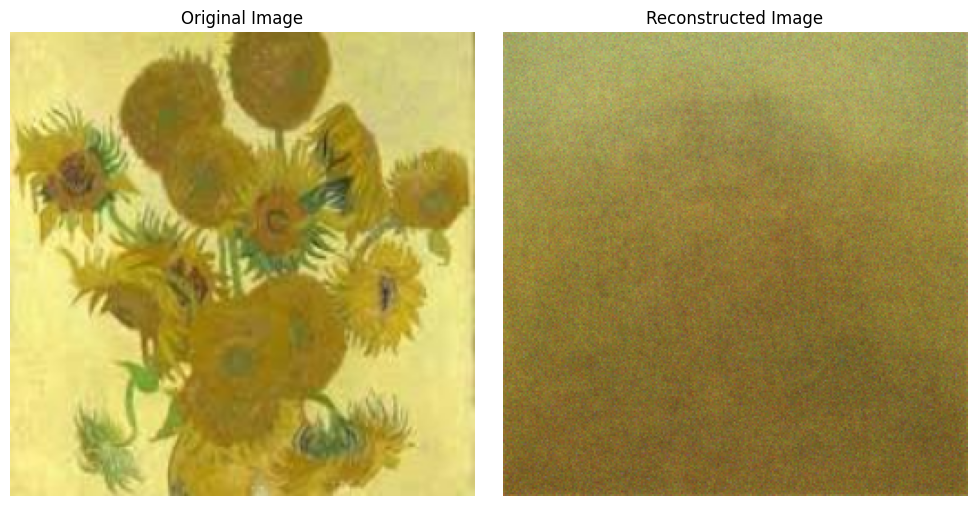

Latent space mean (mu): tensor([[ 1.0486, -1.2473, -0.2454,  2.3645,  2.3486,  1.1328, -1.9879, -1.6430,
          1.2456, -0.3061,  0.9870, -1.5365, -1.5972, -0.6879,  1.4284,  1.5215,
          1.2292, -1.0885,  2.0740,  0.1326]], device='mps:0')
Latent space log-variance (sigma): tensor([[-0.8236,  0.2437,  1.2766,  0.7855,  0.5684,  0.7605, -0.8919, -1.6024,
          1.3518,  0.9090, -0.1055,  0.3288,  1.4663,  0.0310, -0.2482, -0.6917,
          1.4333,  0.4310, -0.8257,  1.2583]], device='mps:0')


In [110]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def run_inference(model, image_path, device, input_dim):
    # Set model to evaluation mode
    model.eval()

    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    image_tensor = image_tensor.view(1, input_dim)

    # Run inference
    with torch.no_grad():
        reconstructed, mu, sigma = model(image_tensor)

    # Reshape the output
    original_image = image_tensor.view(1, 3, 256, 256)
    reconstructed_image = reconstructed.view(1, 3, 256, 256)

    return original_image, reconstructed_image, mu, sigma

# Assuming you've already trained the model and it's stored in 'model'
# and you have an image file to test

image_path = "./Downloads/tst_img.jpeg"
original, reconstructed, mu, sigma = run_inference(model, image_path, device, INPUT_DIM)

# Visualize the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original.cpu().squeeze().permute(1, 2, 0))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed.cpu().squeeze().permute(1, 2, 0))
plt.title("Reconstructed Image")
plt.axis('off')

plt.tight_layout()
plt.show()

# You can also analyze the latent space (mu and sigma) if needed
print("Latent space mean (mu):", mu)
print("Latent space log-variance (sigma):", sigma)